<a href="https://colab.research.google.com/github/KamilBienias/data-science/blob/main/kursPawe%C5%82Krakowiak/neural-network-course/06_cnn/02_binary_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Klasyfikator binarny - Image Classification - Drone vs. Passenger Plane

1. [Import bibliotek](#a0)
2. [Załadowanie danych](#a1)
3. [Przygotowanie zbiorów: treningowego, walidacyjnego i testowego](#a2)
4. [Eksplorcja danych](#a3)
5. [Augmentacja danych](#a4)
6. [Budowa modelu](#a5)
7. [Transfer learning - model VGG16](#a6)
8. [Transfer learning - model VGG16 - odmrożenie kilku ostatnich warstw](#a7)
9. [Ocena modelu na zbiorze testowym](#a8)
10. [Wyświetlenie błędów predykcji](#a9)

### <a name='a0'></a> Import bibliotek

In [4]:
# ######################################################
# Etap 10. Odcinek: Przygotowanie obrazów do modelu.

%tensorflow_version 2.x
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard

np.set_printoptions(precision=6, suppress=True)

### <a name='a1'></a> Załadowanie danych

In [1]:
# unzip rozpakowuje pobrany plik
# !wget https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip
# !unzip -q flying-vehicles.zip

--2021-02-14 12:48:10--  https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.216.128, 173.194.217.128, 74.125.26.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.216.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1540232238 (1.4G) [application/x-zip-compressed]
Saving to: ‘flying-vehicles.zip’

flying-vehicles.zip 100%[===================>]   1.43G   146MB/s    in 13s     

2021-02-14 12:48:24 (113 MB/s) - ‘flying-vehicles.zip’ saved [1540232238/1540232238]



### <a name='a2'></a> Przygotowanie zbiorów: treningowego, walidacyjnego i testowego

In [5]:
# usuwa folder images (jeśli istnieje)
!rm -rf ./images

In [6]:
base_dir = './data/planes'
# sprawdza ile zdjęć dla poszczególnych klas
# do słownika raw number of files mapujemy nazwę klasy i liczbę plików w tym katalogu
raw_no_of_files = {}
# nazwy klas będą kluczami słownika
classes = ['drone', 'fighter-jet', 'helicopter', 'missile', 'passenger-plane', 'rocket']
for dir in classes:
    # os.listdir wylistuje wszystkie pliki w katalogu na przykład ./data/planes/drone
    raw_no_of_files[dir] = len(os.listdir(os.path.join(base_dir, dir)))

raw_no_of_files.items()

dict_items([('drone', 1332), ('fighter-jet', 1867), ('helicopter', 1387), ('missile', 1334), ('passenger-plane', 1424), ('rocket', 1186)])

In [7]:
# tworzy katalog z danymi (jeśli nie istnieje)
data_dir = './images'

if not os.path.exists(data_dir):
    os.mkdir(data_dir)

train_dir = os.path.join(data_dir, 'train')    # katalog zbioru treningowego
valid_dir = os.path.join(data_dir, 'valid')    # katalog zbioru walidacyjnego
test_dir = os.path.join(data_dir, 'test')      # katalog zbioru testowego

train_drone_dir = os.path.join(train_dir, 'drone')
train_passenger_dir = os.path.join(train_dir, 'passenger')

valid_drone_dir = os.path.join(valid_dir, 'drone')
valid_passenger_dir = os.path.join(valid_dir, 'passenger')

test_drone_dir = os.path.join(test_dir, 'drone')
test_passenger_dir = os.path.join(test_dir, 'passenger')

for directory in (train_dir, valid_dir, test_dir):
    if not os.path.exists(directory):
        os.mkdir(directory)

dirs = [train_drone_dir, train_passenger_dir, valid_drone_dir, valid_passenger_dir, test_drone_dir, test_passenger_dir]

for dir in dirs:
    if not os.path.exists(dir):
        os.mkdir(dir)        

In [8]:
# zmienna drone file names przechowuje nazwy plików z katalogu bazowego
drone_fnames = os.listdir(os.path.join(base_dir, 'drone'))
# zmienna passenger file names przechowuje nazwy plików z katalogu bazowego
passenger_fnames = os.listdir(os.path.join(base_dir, 'passenger-plane'))

# wybiera tylko takie rozszerzenia
drone_fnames = [fname for fname in drone_fnames if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]
passenger_fnames = [fname for fname in passenger_fnames if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]

In [9]:
# ######################################################
# Etap 10. Odcinek: Przygotowanie obrazów do modelu cz. 2

# rozmiarem jest minimalna długość z tych dwóch klas
size = min(len(drone_fnames), len(passenger_fnames))

# np.floor obcina mnożenie do mniejszej liczby całkowitej (ucina ułamek)
train_size = int(np.floor(0.7 * size))
valid_size = int(np.floor(0.2 * size))
# zbiór testowy to 10% całości
test_size = size - train_size - valid_size

train_idx = train_size
valid_idx = train_size + valid_size
test_idx = train_size + valid_size + test_size

In [11]:
# kopiowanie zdjęć dronów
for i, fname in enumerate(drone_fnames):
    if i <= train_idx:
        # src source
        src = os.path.join(base_dir, 'drone', fname)
        # dst destination (miejsce przeznaczenia)
        dst = os.path.join(train_drone_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(valid_drone_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(test_drone_dir, fname)
        shutil.copyfile(src, dst)

# # kopiowanie zdjęć samolotów pasażerskich
for i, fname in enumerate(passenger_fnames):
    if i <= train_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(train_passenger_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(valid_passenger_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(test_passenger_dir, fname)
        shutil.copyfile(src, dst) 

print('drone - zbiór treningowy', len(os.listdir(train_drone_dir)))
print('drone - zbiór walidacyjny', len(os.listdir(valid_drone_dir)))
print('drone - zbiór testowy', len(os.listdir(test_drone_dir)))

print('passenger - zbiór treningowy', len(os.listdir(train_passenger_dir)))
print('passenger - zbiór walidacyjny', len(os.listdir(valid_passenger_dir)))
print('passenger - zbiór testowy', len(os.listdir(test_passenger_dir)))               

drone - zbiór treningowy 919
drone - zbiór walidacyjny 262
drone - zbiór testowy 131
passenger - zbiór treningowy 919
passenger - zbiór walidacyjny 262
passenger - zbiór testowy 131


### <a name='a3'></a> Eksplorcja danych

(-0.5, 863.5, 485.5, -0.5)

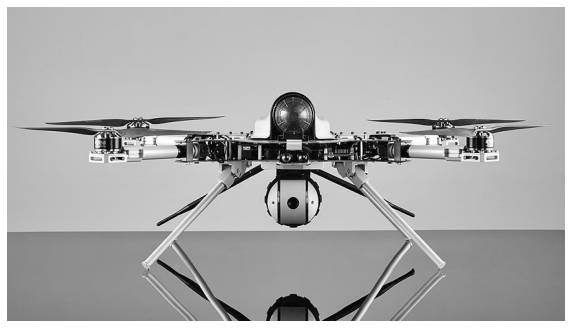

In [16]:
#@title Wybierz indeks przykładowego zdjęcia drona ze zbioru treningowego:

idx = 335 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(drone_fnames))
img_path = os.path.join(train_drone_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 967.5, 680.5, -0.5)

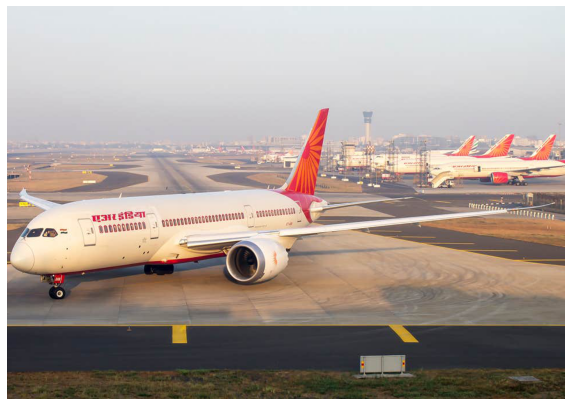

In [15]:
#@title Wybierz indeks przykładowego zdjęcia samolotu pasażerskiego ze zbioru treningowego:

idx = 98 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(passenger_fnames))
img_path = os.path.join(train_passenger_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

### <a name='a4'></a> Augmentcja danych

In [17]:
# będzie więcej danych treningowych
train_datagen = ImageDataGenerator(
    rotation_range=40,     # zakres kąta o który losowo zostanie wykonany obrót obrazów
    rescale=1./255.,
    width_shift_range=0.2,  # pionowe przekształcenia obrazu
    height_shift_range=0.2, # poziome przekształcenia obrazu
    shear_range=0.2,        # zares losowego przycianania obrazu
    zoom_range=0.2,         # zakres losowego przybliżania obrazu
    horizontal_flip=True,   # losowe odbicie połowy obrazu w płaszczyźnie poziomej
    fill_mode='nearest'     # strategia wypełniania nowo utworzonych pikseli, któe mogą powstać w wyniku przekształceń
)

# przeskalowujemy wszystkie obrazy o współczynnik 1/255
valid_datagen = ImageDataGenerator(rescale=1./255.)

# flow_from_dierctory pozwala załadować zdjęcia bezpośrednio do katalogu 
# Katalog train musi zawierać dwa podkatalogi (drone i passenger).
# Stąd keras będzie wiedział, że są dwie klasy
train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='binary')

# flow_from_dierctory pozwala załadować zdjęcia bezpośrednio do katalogu 
# Katalog valid musi zawierać dwa podkatalogi (drone i passenger).
# Stąd keras będzie wiedział, że są dwie klasy
valid_generator = valid_datagen.flow_from_directory(directory=valid_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='binary')

Found 1838 images belonging to 2 classes.
Found 524 images belonging to 2 classes.


In [18]:
# funkcja łapie w locie zdjęcia generowane przez generator (te powykrzywiane).
# One nie są zapisywane na dysku.
def display_augmented_images(directory, idx):
    """
    Funkcja zwraca wykres przykładowych obrazów uzyskanych za pomocą techniki
    augmentacji danych.
    """
    fnames = [os.path.join(directory, fname) for fname in os.listdir(directory)]
    img_path = fnames[idx]
    img = image.load_img(img_path, target_size=(150, 150))

    x = image.img_to_array(img)
    x = x.reshape((1, ) + x.shape)

    i = 1
    plt.figure(figsize=(16, 8))
    for batch in train_datagen.flow(x, batch_size=1):
        plt.subplot(3, 4, i)
        plt.grid(False)
        imgplot = plt.imshow(image.array_to_img(batch[0]))
        i += 1
        if i % 13 == 0:
            break

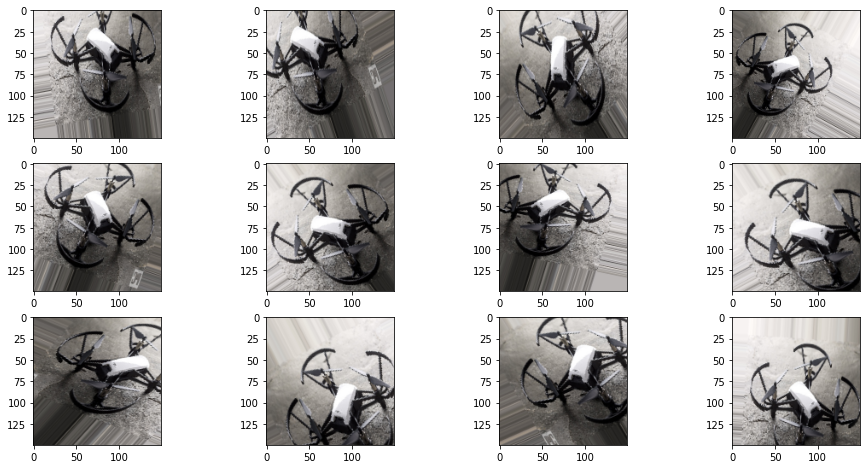

In [27]:
#@title Zbiór treningowy drone:
idx = 547 #@param {type:'slider', min:0, max:919}            
display_augmented_images(train_drone_dir, idx)

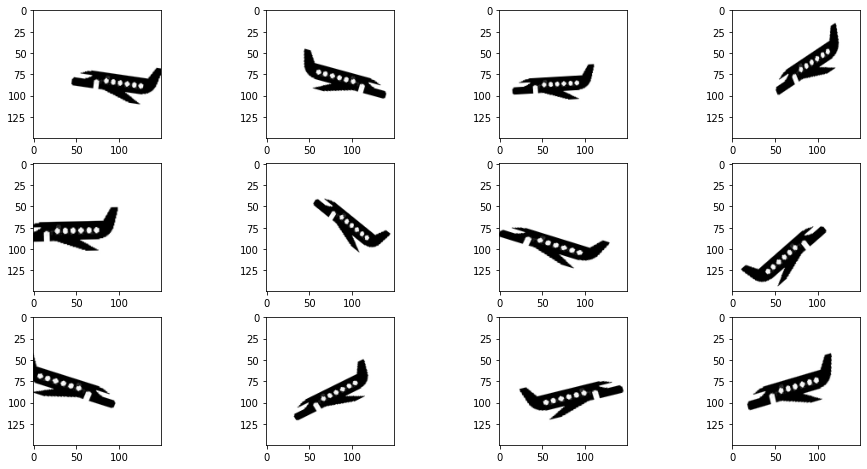

In [28]:
#@title Zbiór treningowy passenger:
idx = 111 #@param {type:'slider', min:0, max:919}
display_augmented_images(train_passenger_dir, idx)

### <a name='a5'></a> Budowa modelu

In [29]:
# ######################################################
# Etap 10. Odcinek: Budowa sieci CNN

# sieć konwolucyjna służy do redukcji wymiarowości i rozpoznawania przestrzennych
# cech ze zdjęć
model = Sequential()
# warstwa konwolucji Conv2D pozwala wykonać operację splotu czyli stosuje filtry i redukuje zdjęcia.
# Rozmiar filtru to 3 na 3
# Wszystkie fotki 150x150 pikseli i kolorowe. Wartstwa konwolucyjna zabiera po 2 z każdego wymiaru
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
# okienko latające po obrazie jest rozmiaru 2 na 2. Ono wyciąga maksymalną wartość piksela.
# Warstwa maxpooling dzieli przez dwa każdy wymiar
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
# do tego momentu operujemy na obrazach 150 na 150 oraz mniejszych (po konwolucji i maxpooling)
# Doszło aż do 7 na 7 ze 128 filtrami. Ale nadal dwu-wymiarowe.
model.add(layers.MaxPooling2D(pool_size=(2, 2)))  
# Dopiro teraz wypłaszcza dane.
model.add(layers.Flatten())
model.add(layers.Dense(units=51-2, activation='relu'))
# w modelu binarnym chcę mieć zwrócone p-two więc sigmoid
model.add(layers.Dense(units=1, activation='sigmoid'))
model.summary() 

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [31]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [32]:
!rm -rf logs
!mkdir logs

# katalog z logami trenowania
tensorboard = TensorBoard(log_dir='logs')

In [33]:
batch_size = 32
steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size

# zamiast fit jest fit_generator bo trenujemy generator,
# bo dokarmiamy model w locie (nie zapisujemy przekształconych zdjęć)
history = model.fit_generator(generator=train_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=30,    # 100
                             validation_data=valid_generator,
                             validation_steps=validation_steps,
                             callbacks=[tensorboard])

/usr/local/lib/python3.6/dist-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/30
28/28 [==============================] - 66s 2s/step - loss: 0.6966 - accuracy: 0.4980 - val_loss: 0.6929 - val_accuracy: 0.4922
Epoch 2/30
28/28 [==============================] - 70s 2s/step - loss: 0.6923 - accuracy: 0.5171 - val_loss: 0.6859 - val_accuracy: 0.5703
Epoch 3/30
28/28 [==============================] - 65s 2s/step - loss: 0.6900 - accuracy: 0.5408 - val_loss: 0.6839 - val_accuracy: 0.5938
Epoch 4/30
28/28 [==============================] - 62s 2s/step - loss: 0.6800 - accuracy: 0.5808 - val_loss: 0.6706 - val_accuracy: 0.6094
Epoch 5/30
28/28 [==============================] - 63s 2s/step - loss: 0.6788 - accuracy: 0.5764 - val_loss: 0.6736 - val_accuracy: 0.5547
Epoch 6/30
28/28 [==============================] - 63s 2s/step - loss: 0.6619 - accuracy: 0.5944 - val_loss: 0.6564 - val_accuracy: 0.6133
Epoch 7/30
28/28 [==============================] - 63s 2s/step - loss: 0.6538 - accuracy: 0.6365 - val_loss: 0.6586 - val_accuracy: 0.5703
Epoch 8/30
28/28 [==

In [34]:
%load_ext tensorboard

In [35]:
!tensorboard dev upload --logdir logs



Interrupted. View your TensorBoard at https://tensorboard.dev/experiment/wGxidqc7SZSJnUyUOClzcw/
Traceback (most recent call last):
  File "/usr/local/bin/tensorboard", line 8, in <module>
    sys.exit(run_main())
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/main.py", line 75, in run_main
    app.run(tensorboard.main, flags_parser=tensorboard.configure)
  File "/usr/local/lib/python3.6/dist-packages/absl/app.py", line 300, in run
    _run_main(main, args)
  File "/usr/local/lib/python3.6/dist-packages/absl/app.py", line 251, in _run_main
    sys.exit(main(argv))
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/program.py", line 289, in main
    return runner(self.flags) or 0
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/uploader/uploader_subcommand.py", line 671, in run
    return _run(flags, self._experiment_url_callback)
  File "/usr/local/lib/python3.6/dist-packages/tensorboard/uploader/uploader_subcommand.py", line 140, in _run
    intent.exec

In [42]:
# takie same wykresy jak w tensorboard
def plot_hist(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['accuracy'], name='accuracy', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_accuracy'], name='val_accuracy', mode='markers+lines'))
    fig.update_layout(width=1000, height=500, title='Accuracy vs. Val Accuracy', xaxis_title='Epoki', yaxis_title='Accuracy', yaxis_type='log')
    fig.show()

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['loss'], name='loss', mode='markers+lines'))
    fig.add_trace(go.Scatter(x=hist['epoch'], y=hist['val_loss'], name='val_loss', mode='markers+lines'))
    fig.update_layout(width=900, height=500, title='Loss vs. Val Loss', xaxis_title='Epoki', yaxis_title='Loss', yaxis_type='log')
    fig.show()

plot_hist(history)

### <a name='a6'></a> Transfer learning - model VGG16

In [37]:
# ######################################################
# Etap 10. Odcinek: Transfer Learning - model VGG16

# Gdy mam mały zbiór danych i chcę poprawić dokładność klasyfikacji to:
# bierzemy gotową architekturę modelu i gotowe wagi, które zostały przetrenowane
# na bardzo dużym zbiorze obrazów o wielu różnych klasach (etykietach).
# Dokładamy nasze warstwy które będą trenowane, a reszta wartst z oryginalnego
# modelu będzie zamrożona.

from tensorflow.keras.applications import VGG16

# jednym z gotowych modeli jest VGG16. Skorzystamy z jego architektury.
# Ma 16 warstw tak jak w nazwie.
# Więcej modeli w dokumentacji keras w zakładce applications.
# Zbiór imagenet to kilkanaście milionów zdjęć
# include_top=False bo chcemy dorzucić nasze warstwy
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.summary()
# ze zdjęcia 150,150,3 robi 4,4,512

58892288/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
______________________________________________________________

In [38]:
model = Sequential()
# jako pierwszą warstwę dodaje cały pobrany model (jego architekturę)
model.add(conv_base)
# wypłaszczy wejście 4 na 4
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [39]:
# chcemy trenować tylko te warstwy które dodaliśmy. Nie ma sensu jeszcze raz trenować
# pobrany model
print(f'Liczba warstw trenowanych przed zamrożeniem {len(model.trainable_weights)}')
# zamraża warstwy
conv_base.trainable = False
print(f'Liczba warstw trenowanych po zamrożeniu {len(model.trainable_weights)}')
# te 4 warstwy to te które dodaliśmy

Liczba warstw trenowanych przed zamrożeniem 30
Liczba warstw trenowanych po zamrożeniu 4


In [40]:
model.compile(optimizer=optimizers.RMSprop(lr=1e-4),
             loss='binary_crossentropy',
             metrics=['accuracy'])

In [41]:
# długo się trenował więc przerwałem
history = model.fit_generator(generator=train_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=50,    # 100
                             validation_data=valid_generator,
                             validation_steps=validation_steps,
                             callbacks=[tensorboard])

KeyboardInterrupt: ignored

In [ ]:
import plotly.graph_objects as go
plot_hist(history)

### <a name='a7'></a> Transfer learning - model VGG16 - odmrożenie kilku ostatnich warstw

In [ ]:
# odmraża kilka ostatnich warstw aby nasze dostarczone wzorce były
# lepiej rozpoznawalne

conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))
conv_base.trainable = True

def print_layers(model):
    for layer in model.layers:
        print(f'layer_name: {layer.name:13} trainable: {layer.trainable}')

print_layers(conv_base)

layer_name: input_2       trainable: True
layer_name: block1_conv1  trainable: True
layer_name: block1_conv2  trainable: True
layer_name: block1_pool   trainable: True
layer_name: block2_conv1  trainable: True
layer_name: block2_conv2  trainable: True
layer_name: block2_pool   trainable: True
layer_name: block3_conv1  trainable: True
layer_name: block3_conv2  trainable: True
layer_name: block3_conv3  trainable: True
layer_name: block3_pool   trainable: True
layer_name: block4_conv1  trainable: True
layer_name: block4_conv2  trainable: True
layer_name: block4_conv3  trainable: True
layer_name: block4_pool   trainable: True
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_pool   trainable: True


In [ ]:
set_trainable = False
for layer in conv_base.layers:
    # od tej warstwy kolejne mają być trenowane
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

print_layers(conv_base)

layer_name: input_2       trainable: False
layer_name: block1_conv1  trainable: False
layer_name: block1_conv2  trainable: False
layer_name: block1_pool   trainable: False
layer_name: block2_conv1  trainable: False
layer_name: block2_conv2  trainable: False
layer_name: block2_pool   trainable: False
layer_name: block3_conv1  trainable: False
layer_name: block3_conv2  trainable: False
layer_name: block3_conv3  trainable: False
layer_name: block3_pool   trainable: False
layer_name: block4_conv1  trainable: False
layer_name: block4_conv2  trainable: False
layer_name: block4_conv3  trainable: False
layer_name: block4_pool   trainable: False
layer_name: block5_conv1  trainable: True
layer_name: block5_conv2  trainable: True
layer_name: block5_conv3  trainable: True
layer_name: block5_pool   trainable: True


In [ ]:
model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=1e-5),
             loss='binary_crossentropy',
             metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 9,177,089
Non-trainable params: 7,635,264
_________________________________________________________________


In [ ]:
history = model.fit_generator(generator=train_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=30,    # 100
                             validation_data=valid_generator,
                             validation_steps=validation_steps,
                             callbacks=[tensorboard])

Epoch 1/30
28/28 [==============================] - 28s 991ms/step - loss: 0.6426 - accuracy: 0.6362 - val_loss: 0.5774 - val_accuracy: 0.7305
Epoch 2/30
28/28 [==============================] - 21s 751ms/step - loss: 0.5706 - accuracy: 0.6913 - val_loss: 0.5175 - val_accuracy: 0.7305
Epoch 3/30
28/28 [==============================] - 24s 856ms/step - loss: 0.5001 - accuracy: 0.7563 - val_loss: 0.4750 - val_accuracy: 0.7578
Epoch 4/30
28/28 [==============================] - 25s 883ms/step - loss: 0.5027 - accuracy: 0.7478 - val_loss: 0.4696 - val_accuracy: 0.7578
Epoch 5/30
28/28 [==============================] - 26s 916ms/step - loss: 0.4530 - accuracy: 0.7768 - val_loss: 0.4494 - val_accuracy: 0.7539
Epoch 6/30
28/28 [==============================] - 23s 830ms/step - loss: 0.4523 - accuracy: 0.7756 - val_loss: 0.4442 - val_accuracy: 0.7578
Epoch 7/30
28/28 [==============================] - 23s 805ms/step - loss: 0.4353 - accuracy: 0.7813 - val_loss: 0.4158 - val_accuracy: 0.7812

In [ ]:
plot_hist(history)

### <a name='a8'></a> Ocena modelu na zbiorze testowym

In [ ]:
# dla generatora zbioru walidacyjnego lub testowego jedynym parametrem
# ktory można zmieniać to rescale
test_datagen = ImageDataGenerator(rescale=1./255.)
test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(150, 150),
    batch_size=1,
    class_mode='binary',
    # nie chcemy przetasowania danych (domyślnie ma True)
    shuffle=False
)

y_prob = model.predict_generator(test_generator, test_generator.samples)
y_prob = y_prob.ravel()
y_prob
# Klasyfikacja binarna, dlatego
# tam gdzie wartości poniżej 0.5 to przypisuje klasę 0
# a tam gdzie powyżej 0.5 to klasę 1

Found 262 images belonging to 2 classes.


array([0.000721, 0.000626, 0.491422, 0.000145, 0.000468, 0.007793,
       0.39827 , 0.022215, 0.211716, 0.018222, 0.055266, 0.384794,
       0.008386, 0.062967, 0.975671, 0.950429, 0.054353, 0.000087,
       0.24652 , 0.004199, 0.025838, 0.892163, 0.002302, 0.000157,
       0.000323, 0.001803, 0.195412, 0.012264, 0.027774, 0.583916,
       0.000077, 0.01907 , 0.640695, 0.104861, 0.493349, 0.023813,
       0.052225, 0.310432, 0.024091, 0.067575, 0.231779, 0.044637,
       0.00651 , 0.000088, 0.015827, 0.073946, 0.051724, 0.354414,
       0.858222, 0.042161, 0.000318, 0.74375 , 0.085473, 0.69694 ,
       0.037782, 0.001062, 0.049049, 0.009418, 0.036785, 0.606805,
       0.038109, 0.013476, 0.565314, 0.000156, 0.081812, 0.640176,
       0.001189, 0.205855, 0.028435, 0.034495, 0.188818, 0.103956,
       0.197921, 0.085822, 0.018736, 0.057483, 0.730161, 0.006502,
       0.033621, 0.037349, 0.338993, 0.173777, 0.004079, 0.149812,
       0.010057, 0.257478, 0.32267 , 0.204448, 0.562731, 0.515

In [ ]:
predictions  = pd.DataFrame({'y_prob': y_prob})
predictions['class'] = predictions['y_prob'].apply(lambda x: 1 if x > 0.5 else 0)
predictions

,y_prob,class
0,0.000721,0
1,0.000626,0
2,0.491422,0
3,0.000145,0
4,0.000468,0
...,...,...
257,0.908467,1
258,0.998282,1
259,0.444252,0
260,0.222812,0


In [ ]:
# klasy jakie naprawdę były
y_true = test_generator.classes
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)

In [ ]:
# klasy przewidziane
y_pred = predictions['class'].values
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1])

In [ ]:
# nie podawaliśmy jawnie klas do generatorów. One były przypisane
# na podstawie katalogów. Dla drona przypisał klasę 0, a dla 
# samolotu pasażerskiego 1
test_generator.class_indices

{'drone': 0, 'passenger': 1}

In [ ]:
cm = confusion_matrix(y_true, y_pred)
cm
# drony jako samoloty zostały źle sklasyfikowane w 22 przypadkach

array([[109,  22],
       [ 16, 115]])

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85       131
           1       0.84      0.88      0.86       131

    accuracy                           0.85       262
   macro avg       0.86      0.85      0.85       262
weighted avg       0.86      0.85      0.85       262



### <a name='a9'></a> Wyświetlenie błędów predykcji

In [ ]:
# ######################################################
# Etap 10. Odcinek: Wyświetlenie błędów predykcji

errors = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}, index=test_generator.filenames)
errors.head()

,y_true,y_pred
drone/00000010.jpg,0,0
drone/00000013.jpg,0,0
drone/00000032.jpg,0,0
drone/00000041.jpg,0,0
drone/00000048.jpg,0,0


In [ ]:
# z True robi 1, a z False robi 0
errors['is_incorrect'] = (errors['y_true'] != errors['y_pred']) * 1
errors

,y_true,y_pred,is_incorrect
drone/00000010.jpg,0,0,0
drone/00000013.jpg,0,0,0
drone/00000032.jpg,0,0,0
drone/00000041.jpg,0,0,0
drone/00000048.jpg,0,0,0
...,...,...,...
passenger/00001434.jpg,1,1,0
passenger/00001447.jpg,1,1,0
passenger/00001452.jpg,1,0,1
passenger/00001453.jpg,1,0,1


In [ ]:
# zdjęcia błędnie sklasyfikowane (nazwy zdjęć są indeksami w df)
errors[errors['is_incorrect'] == 1].index

Index(['drone/00000175.jpg', 'drone/00000183.JPG', 'drone/00000245.jpg',
       'drone/00000317.jpg', 'drone/00000339.jpg', 'drone/00000532.JPG',
       'drone/00000554.png', 'drone/00000581.jpg', 'drone/00000692.jpg',
       'drone/00000716.jpg', 'drone/00000745.jpg', 'drone/00000806.jpg',
       'drone/00000904.jpg', 'drone/00000929.jpg', 'drone/00000933.jpg',
       'drone/00000952.jpg', 'drone/00001101.jpg', 'drone/00001110.jpg',
       'drone/00001124.jpg', 'drone/00001148.jpg', 'drone/00001314.jpg',
       'drone/00001354.jpg', 'passenger/00000156.jpg',
       'passenger/00000410.jpg', 'passenger/00000464.jpg',
       'passenger/00000485.jpg', 'passenger/00000648.jpg',
       'passenger/00000675.jpg', 'passenger/00000677.jpg',
       'passenger/00000731.JPG', 'passenger/00000745.jpg',
       'passenger/00000771.jpg', 'passenger/00000809.jpg',
       'passenger/00000897.jpg', 'passenger/00001066.jpg',
       'passenger/00001104.jpg', 'passenger/00001452.jpg',
       'passenger/000

(-0.5, 749.5, 499.5, -0.5)

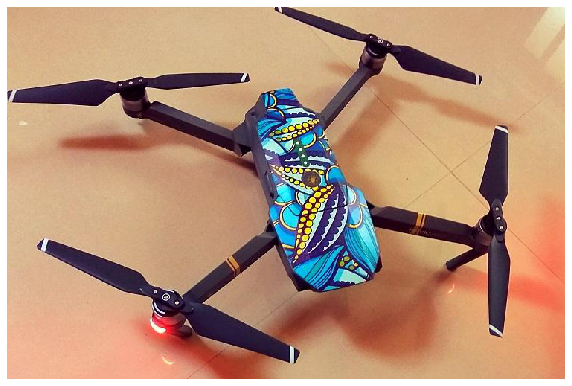

In [ ]:
img_path = os.path.join(test_drone_dir, '00000183.JPG')

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

In [ ]:
errors[errors['is_incorrect'] == 1].index

Index(['drone/00000175.jpg', 'drone/00000183.JPG', 'drone/00000245.jpg',
       'drone/00000317.jpg', 'drone/00000339.jpg', 'drone/00000532.JPG',
       'drone/00000554.png', 'drone/00000581.jpg', 'drone/00000692.jpg',
       'drone/00000716.jpg', 'drone/00000745.jpg', 'drone/00000806.jpg',
       'drone/00000904.jpg', 'drone/00000929.jpg', 'drone/00000933.jpg',
       'drone/00000952.jpg', 'drone/00001101.jpg', 'drone/00001110.jpg',
       'drone/00001124.jpg', 'drone/00001148.jpg', 'drone/00001314.jpg',
       'drone/00001354.jpg', 'passenger/00000156.jpg',
       'passenger/00000410.jpg', 'passenger/00000464.jpg',
       'passenger/00000485.jpg', 'passenger/00000648.jpg',
       'passenger/00000675.jpg', 'passenger/00000677.jpg',
       'passenger/00000731.JPG', 'passenger/00000745.jpg',
       'passenger/00000771.jpg', 'passenger/00000809.jpg',
       'passenger/00000897.jpg', 'passenger/00001066.jpg',
       'passenger/00001104.jpg', 'passenger/00001452.jpg',
       'passenger/000

(-0.5, 589.5, 417.5, -0.5)

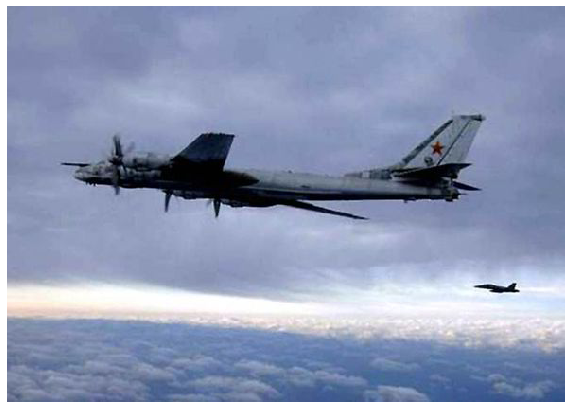

In [ ]:
img_path = os.path.join(test_passenger_dir, '00001453.jpg')

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)